In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
import matplotlib.pyplot as plt
import os
import requests

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import set_config
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [3]:
train_data=pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")

In [4]:
train_data.Status.unique()

array(['IC', 'AO', 'AA', 'JA', 'JO'], dtype=object)

In [5]:
train_data.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [6]:
train_data.columns

Index(['Location', 'Cross_Street', 'Latitude', 'Longitude', 'Date_Reported',
       'Date_Occurred', 'Time_Occurred', 'Area_ID', 'Area_Name',
       'Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Weapon_Used_Code', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')

In [7]:
print(train_data.shape)
print(train_data.info())

(20000, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  obj

In [8]:
train_data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [9]:
train_data['Part 1-2'].unique()

array([1., 2.])

In [10]:
train_data.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [11]:
# Convert date columns to datetime
train_data['Date_Reported'] = pd.to_datetime(train_data['Date_Reported'])
train_data['Date_Occurred'] = pd.to_datetime(train_data['Date_Occurred'])
# Extract features from date columns
train_data['Year_Occurred'] = train_data['Date_Occurred'].dt.year
train_data['Month_Occurred'] = train_data['Date_Occurred'].dt.month
train_data['Day_Occurred'] = train_data['Date_Occurred'].dt.day
train_data['Hour_Occurred'] = train_data['Time_Occurred'] // 100

/tmp/ipykernel_17/268340801.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Date_Reported'] = pd.to_datetime(train_data['Date_Reported'])
/tmp/ipykernel_17/268340801.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Date_Occurred'] = pd.to_datetime(train_data['Date_Occurred'])


In [12]:
x=train_data.drop(['Crime_Category','Status_Description','Date_Reported','Time_Occurred', 'Date_Occurred'],axis=1)
y=train_data['Crime_Category']

In [13]:
#x=train_data.drop(['Crime_Category',axis=1)
#y=train_data['Crime_Category']

In [14]:
#x.columns

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

In [16]:
#DummyClassifier
'''
from sklearn.dummy import DummyClassifier
model=DummyClassifier(strategy='most_frequent')
model.fit(x_train,y_train)
'''

"\nfrom sklearn.dummy import DummyClassifier\nmodel=DummyClassifier(strategy='most_frequent')\nmodel.fit(x_train,y_train)\n"

In [17]:
x_train.replace('?',np.nan,inplace=True)
x_train.replace({'Victim_Age':[0,-1,-2]},np.nan,inplace=True)

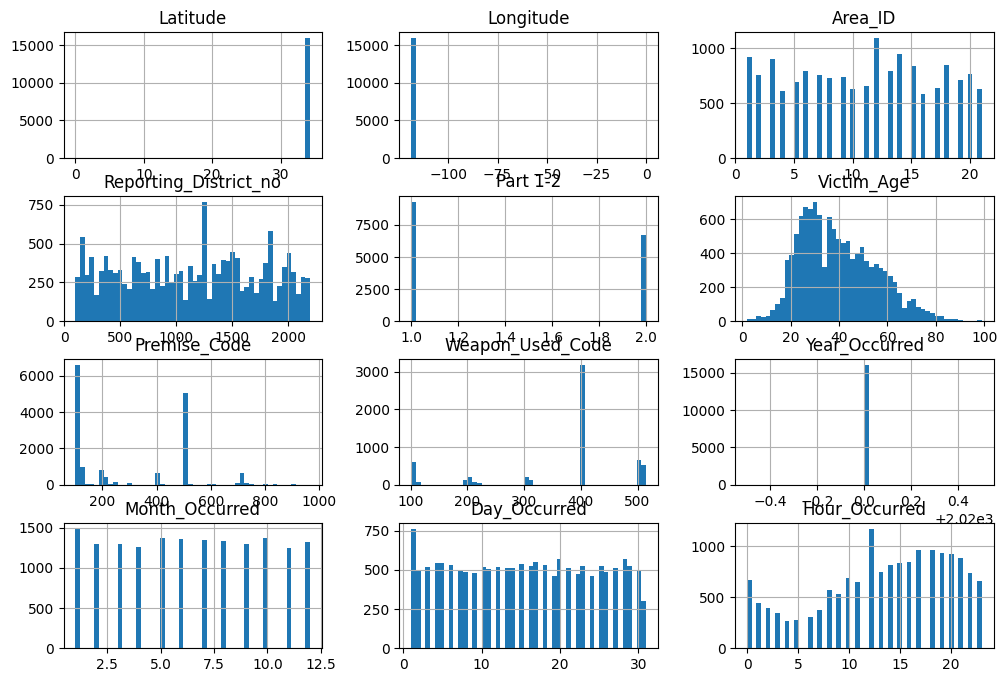

In [18]:
x_train.hist(bins=50, figsize=(12,8))
plt.show() 

In [19]:
x_train['Modus_Operandi']

5894                    0337 0334 0344
3728                         0444 0913
8958                         0344 1606
7671               1822 0344 0329 1300
5999                              0344
                     ...              
11284         0913 2000 1243 0444 0429
11964                              NaN
5390                               NaN
860      2000 0913 1813 1821 0416 0444
15795                              NaN
Name: Modus_Operandi, Length: 16000, dtype: object

In [20]:
'''x_train['Modus_Operandi']
my_list4=[('most-frequent',SimpleImputer(strategy='most_frequent'),['Modus_Operandi'])]
column_trans=ColumnTransformer(transformers=my_list4,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
#enc1=LabelEncoder()
#x_train['Modus_Operandi']=enc1.fit_transform(x_train['Modus_Operandi'])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
x_train['Modus_Operandi']=mlb.fit_transform(x_train['Modus_Operandi'])
'''

"x_train['Modus_Operandi']\nmy_list4=[('most-frequent',SimpleImputer(strategy='most_frequent'),['Modus_Operandi'])]\ncolumn_trans=ColumnTransformer(transformers=my_list4,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\n#enc1=LabelEncoder()\n#x_train['Modus_Operandi']=enc1.fit_transform(x_train['Modus_Operandi'])\nfrom sklearn.preprocessing import MultiLabelBinarizer\nmlb = MultiLabelBinarizer()\nx_train['Modus_Operandi']=mlb.fit_transform(x_train['Modus_Operandi'])\n"

In [21]:
'''my_list=[('mean',SimpleImputer(strategy='mean'),['Latitude', 'Longitude','Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code'])]
ct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
simple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Area_Name','Victim_Sex','Victim_Descent','Premise_Description',
                                                                  'Weapon_Description','Status'])]
ct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
my_list3=[('std',StandardScaler(),['Latitude', 'Longitude', 'Hour_Occurred', 'Area_ID','Year_Occurred','Month_Occurred','Day_Occurred',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code']),
        ('ohe',OneHotEncoder( handle_unknown='ignore',sparse_output=False),['Location','Cross_Street','Area_Name','Victim_Sex','Victim_Descent','Premise_Description','Weapon_Description','Status'])]
ct3=ColumnTransformer(transformers=my_list3,verbose_feature_names_out=False)
'''

"my_list=[('mean',SimpleImputer(strategy='mean'),['Latitude', 'Longitude','Area_ID',\n       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',\n       'Weapon_Used_Code'])]\nct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\nsimple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Area_Name','Victim_Sex','Victim_Descent','Premise_Description',\n                                                                  'Weapon_Description','Status'])]\nct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\nmy_list3=[('std',StandardScaler(),['Latitude', 'Longitude', 'Hour_Occurred', 'Area_ID','Year_Occurred','Month_Occurred','Day_Occurred',\n       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',\n       'Weapon_Used_Code']),\n        ('ohe',OneHotEncoder( handle_unknown='

In [22]:
x_train.columns
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 5894 to 15795
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               16000 non-null  object 
 1   Cross_Street           2741 non-null   object 
 2   Latitude               16000 non-null  float64
 3   Longitude              16000 non-null  float64
 4   Area_ID                16000 non-null  float64
 5   Area_Name              16000 non-null  object 
 6   Reporting_District_no  16000 non-null  float64
 7   Part 1-2               16000 non-null  float64
 8   Modus_Operandi         13770 non-null  object 
 9   Victim_Age             12088 non-null  float64
 10  Victim_Sex             13865 non-null  object 
 11  Victim_Descent         13865 non-null  object 
 12  Premise_Code           16000 non-null  float64
 13  Premise_Description    15996 non-null  object 
 14  Weapon_Used_Code       5832 non-null   float64
 15  Weap

In [23]:
my_list=[('mean',SimpleImputer(strategy='mean'),['Latitude', 'Longitude', 'Hour_Occurred', 'Area_ID',
       'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code'])]
ct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
simple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description',
                                                                  'Weapon_Description','Status'])]
ct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
my_list3=[('std',StandardScaler(),['Latitude', 'Longitude','Hour_Occurred','Area_ID','Year_Occurred','Month_Occurred','Day_Occurred',
       'Part 1-2', 'Victim_Age', 'Premise_Code','Reporting_District_no',
       'Weapon_Used_Code']),
        ('ohe',OneHotEncoder( handle_unknown='ignore',sparse_output=False),['Location','Cross_Street','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description','Weapon_Description','Status'])]
ct3=ColumnTransformer(transformers=my_list3,verbose_feature_names_out=False)

In [24]:
'''my_list=[('mean',SimpleImputer(strategy='mean'),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code'])]
ct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
simple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description',
                                                                  'Weapon_Description','Status'])]
ct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
my_list3=[('std',StandardScaler(),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code']),
        ('ohe',OneHotEncoder( handle_unknown='ignore',sparse_output=False),['Location','Cross_Street','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description','Weapon_Description','Status','Status_Description'])]
ct3=ColumnTransformer(transformers=my_list3,verbose_feature_names_out=False)'''


"my_list=[('mean',SimpleImputer(strategy='mean'),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',\n       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',\n       'Weapon_Used_Code'])]\nct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\nsimple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description',\n                                                                  'Weapon_Description','Status'])]\nct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\nmy_list3=[('std',StandardScaler(),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',\n       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',\n       'Weapon_Used_Code']),\n        ('ohe',OneHotEncoder( handle_unknown='ignore',spars

In [25]:
'''
my_list=[('mean',KNNImputer(n_neighbors=6),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code'])]
ct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
simple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Date_Reported','Date_Occurred','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description',
                                                                  'Weapon_Description','Status','Status_Description'])]
ct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
my_list3=[('std',StandardScaler(),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code']),
        ('ohe',OneHotEncoder( handle_unknown='ignore',sparse_output=False),['Location','Cross_Street','Date_Reported','Date_Occurred','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description','Weapon_Description','Status','Status_Description'])]
ct3=ColumnTransformer(transformers=my_list3,verbose_feature_names_out=False)
step=[('ct1',ct1),
      ('ct2',ct2),
      ('ct3',ct3)]
pipe=Pipeline(steps=step)
'''

"\nmy_list=[('mean',KNNImputer(n_neighbors=6),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',\n       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',\n       'Weapon_Used_Code'])]\nct1=ColumnTransformer(transformers=my_list,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\nsimple=[('most_frequent',SimpleImputer(strategy='most_frequent'),['Location','Cross_Street','Date_Reported','Date_Occurred','Area_Name','Modus_Operandi','Victim_Sex','Victim_Descent','Premise_Description',\n                                                                  'Weapon_Description','Status','Status_Description'])]\nct2=ColumnTransformer(transformers=simple,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\nmy_list3=[('std',StandardScaler(),['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',\n       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',\n       'Weapon_Used_Code']),\n        (

In [26]:
#transformed_X_train=ct1.fit_transform(x_train)
#final_x_train=ct2.fit_transform(transformed_X_train)
#final_X_train1=ct3.fit_transform(final_x_train)

In [27]:
step=[('ct1',ct1),
      ('ct2',ct2),
      ('ct3',ct3)]
pipe=Pipeline(steps=step)
transformed_X_train=pipe.fit_transform(x_train)


In [28]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
y_encoded_train=enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [30]:
x_val.replace('?',np.nan,inplace=True)
x_val.replace({'Victim_Age':[0,-1,-2]},np.nan,inplace=True)
#my_list4=[('median',SimpleImputer(strategy='median'),['Modus_Operandi'])]
#column_trans=ColumnTransformer(transformers=my_list4,remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
#enc1=LabelEncoder()
#x_val['Modus_Operandi']=enc1.fit_transform(x_val['Modus_Operandi'])
transformed_x_val=pipe.transform(x_val)


In [31]:
'''randclas=RandomForestClassifier()
randclas.fit(transformed_X_train,y_encoded_train)
randclas.score(transformed_X_train,y_encoded_train)
randclas.score(transformed_x_val,y_val_encoded)
'''
0.837

0.837

In [32]:
'''param_grid= {'knn__n_neighbors':list(range(1,31))}
pipe1=Pipeline([('minmax',MinMaxScaler()),
               ('knn',KNeighborsClassifier())])
gcv=GridSearchCV(estimator=pipe1,
                 param_grid=param_grid,
                 cv=4,
                 n_jobs=-2,
                 scoring='accuracy'
                 )
gcv.fit(transformed_X_train,y_encoded_train)
gcv.score(transformed_X_train,y_encoded_train)
gcv.score(transformed_x_val,y_val_encoded)'''

"param_grid= {'knn__n_neighbors':list(range(1,31))}\npipe1=Pipeline([('minmax',MinMaxScaler()),\n               ('knn',KNeighborsClassifier())])\ngcv=GridSearchCV(estimator=pipe1,\n                 param_grid=param_grid,\n                 cv=4,\n                 n_jobs=-2,\n                 scoring='accuracy'\n                 )\ngcv.fit(transformed_X_train,y_encoded_train)\ngcv.score(transformed_X_train,y_encoded_train)\ngcv.score(transformed_x_val,y_val_encoded)"

In [33]:
#BaggingClassifier
'''from sklearn.ensemble import BaggingClassifier
bag=BaggingClassifier(random_state = 1)
bag.fit(transformed_X_train,y_encoded_train)
bag.score(transformed_X_train,y_encoded_train)
bag.score(transformed_x_val,y_val_encoded)'''
#Score = 0.86825

'from sklearn.ensemble import BaggingClassifier\nbag=BaggingClassifier(random_state = 1)\nbag.fit(transformed_X_train,y_encoded_train)\nbag.score(transformed_X_train,y_encoded_train)\nbag.score(transformed_x_val,y_val_encoded)'

In [34]:
#BoostingClassifier
'''from sklearn.ensemble import GradientBoostingClassifier
boost=GradientBoostingClassifier(random_state = 1)
boost.fit(transformed_X_train,y_encoded_train)
boost.score(transformed_X_train,y_encoded_train)
boost.score(transformed_x_val,y_val_encoded)'''

'from sklearn.ensemble import GradientBoostingClassifier\nboost=GradientBoostingClassifier(random_state = 1)\nboost.fit(transformed_X_train,y_encoded_train)\nboost.score(transformed_X_train,y_encoded_train)\nboost.score(transformed_x_val,y_val_encoded)'

In [35]:
'''knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(transformed_X_train,y_encoded_train)
knn.score(transformed_X_train,y_encoded_train)
knn.score(transformed_x_val,y_val_encoded)'''
#score was 0.7555

'knn=KNeighborsClassifier(n_neighbors=3)\nknn.fit(transformed_X_train,y_encoded_train)\nknn.score(transformed_X_train,y_encoded_train)\nknn.score(transformed_x_val,y_val_encoded)'

In [36]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(hidden_layer_sizes=(45,), activation="relu",solver="sgd", alpha=1e-4,learning_rate='constant',max_iter=1500, random_state=1)
mlp.fit(transformed_X_train,y_encoded_train)
mlp.score(transformed_X_train,y_encoded_train)
mlp.score(transformed_x_val,y_val_encoded)
# score 0.87925
# score 0.88325
# score 0.891


0.89075

In [37]:
'''from sklearn.neural_network import MLPClassifier
#param_grid2={'hidden_layer_sizes': [(50,), (100,)],
#            'max_iter':[500, 1000]
#           }
MLPGCV=GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(50,),activation="relu",solver="sgd", alpha=1e-4,learning_rate='constant',max_iter=1000,random_state=1),
                 param_grid=param_grid2,
                 cv=4,
                 n_jobs=-1,
                 scoring='accuracy'
                  )                           
MLPGCV.fit(transformed_X_train,y_encoded_train)
MLPGCV.score(transformed_X_train,y_encoded_train)
MLPGCV.score(transformed_x_val,y_val_encoded)'''

'from sklearn.neural_network import MLPClassifier\n#param_grid2={\'hidden_layer_sizes\': [(50,), (100,)],\n#            \'max_iter\':[500, 1000]\n#           }\nMLPGCV=GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(50,),activation="relu",solver="sgd", alpha=1e-4,learning_rate=\'constant\',max_iter=1000,random_state=1),\n                 param_grid=param_grid2,\n                 cv=4,\n                 n_jobs=-1,\n                 scoring=\'accuracy\'\n                  )                           \nMLPGCV.fit(transformed_X_train,y_encoded_train)\nMLPGCV.score(transformed_X_train,y_encoded_train)\nMLPGCV.score(transformed_x_val,y_val_encoded)'

In [38]:
'''from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
clf1  = BaggingClassifier(random_state = 1)
clf2 = RandomForestClassifier(random_state = 1)
clf3 = GradientBoostingClassifier(random_state = 1)

model = VotingClassifier(estimators = [('bc',clf1),('rf',clf2),('gb',clf3)])
model.fit(transformed_X_train,y_encoded_train)
model.score(transformed_X_train,y_encoded_train)
model.score(transformed_x_val,y_val_encoded)
'''

"from sklearn.ensemble import BaggingClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.ensemble import GradientBoostingClassifier\n\nfrom sklearn.ensemble import VotingClassifier\nclf1  = BaggingClassifier(random_state = 1)\nclf2 = RandomForestClassifier(random_state = 1)\nclf3 = GradientBoostingClassifier(random_state = 1)\n\nmodel = VotingClassifier(estimators = [('bc',clf1),('rf',clf2),('gb',clf3)])\nmodel.fit(transformed_X_train,y_encoded_train)\nmodel.score(transformed_X_train,y_encoded_train)\nmodel.score(transformed_x_val,y_val_encoded)\n"

***SVM Models - SVC, NuSVC, LinearSVC***

In [39]:
'''svc=SVC(gamma='auto')
svc.fit(transformed_X_train,y_encoded_train)
svc.score(transformed_X_train,y_encoded_train)
svc.score(transformed_x_val,y_val_encoded)'''

"svc=SVC(gamma='auto')\nsvc.fit(transformed_X_train,y_encoded_train)\nsvc.score(transformed_X_train,y_encoded_train)\nsvc.score(transformed_x_val,y_val_encoded)"

In [40]:
'''from sklearn.tree import DecisionTreeClassifier
dct=DecisionTreeClassifier(random_state=1)
param_grid={'criterion':['entropy','gini'], "splitter":['random','best'],'min_samples_leaf':[2,4,6,8,10],'max_depth':[3,4,5,6]}
gcv=GridSearchCV(dct,param_grid,cv=4,n_jobs=-1)
'''


'from sklearn.tree import DecisionTreeClassifier\ndct=DecisionTreeClassifier(random_state=1)\nparam_grid={\'criterion\':[\'entropy\',\'gini\'], "splitter":[\'random\',\'best\'],\'min_samples_leaf\':[2,4,6,8,10],\'max_depth\':[3,4,5,6]}\ngcv=GridSearchCV(dct,param_grid,cv=4,n_jobs=-1)\n'

In [41]:
'''from sklearn.tree import DecisionTreeRegressor
dct=DecisionTreeRegressor(random_state=1)
param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], "splitter":['random','best'],'max_features':[4,5,6,'sqrt', 'log2'],'ccp': [0.001,0.01,0.02,0.05]}
gcv=GridSearchCV(dct,param_grid,cv=4,n_jobs=-1)
'''

'from sklearn.tree import DecisionTreeRegressor\ndct=DecisionTreeRegressor(random_state=1)\nparam_grid={\'criterion\':[\'squared_error\', \'friedman_mse\', \'absolute_error\', \'poisson\'], "splitter":[\'random\',\'best\'],\'max_features\':[4,5,6,\'sqrt\', \'log2\'],\'ccp\': [0.001,0.01,0.02,0.05]}\ngcv=GridSearchCV(dct,param_grid,cv=4,n_jobs=-1)\n'

In [42]:
'''gcv.fit(transformed_X_train,y_encoded_train)
gcv.score(transformed_X_train,y_encoded_train)
gcv.score(transformed_x_val,y_val_encoded)'''

'gcv.fit(transformed_X_train,y_encoded_train)\ngcv.score(transformed_X_train,y_encoded_train)\ngcv.score(transformed_x_val,y_val_encoded)'

In [43]:
#clf = LogisticRegression(random_state=0)

In [44]:
#dct.fit(final_X_train1,y_encoded_train)
#dct.score(final_X_train1,y_encoded_train)

In [45]:
#gcv.score(final_X_train1,y_encoded_train)

In [46]:
#X_val1=ct1.transform(x_val)
#X_val2=ct2.transform(X_val1)
#X_val1=ct3.transform(X_val2)

In [47]:
#dct.score(X_val1,y_val_encoded)
#gcv.score(X_val1,y_val_encoded)
#randclas.score(X_val1,y_val_encoded)


In [48]:
sample=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv')
sample.head()

,ID,Crime_Category,Unnamed: 2
0,1,Crimes against Persons,NaN
1,2,Crimes against Public Order,NaN
2,3,Other Crimes,NaN
3,4,Crimes against Public Order,NaN
4,5,Other Crimes,NaN


In [49]:
X_test=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
X_test.shape
X_test.drop(['Status_Description'],axis=1)

# Convert date columns to datetime for test data
X_test['Date_Reported'] = pd.to_datetime(X_test['Date_Reported'])
X_test['Date_Occurred'] = pd.to_datetime(X_test['Date_Occurred'])

X_test['Year_Occurred'] = X_test['Date_Occurred'].dt.year
X_test['Month_Occurred'] = X_test['Date_Occurred'].dt.month
X_test['Day_Occurred'] = X_test['Date_Occurred'].dt.day
X_test['Hour_Occurred'] = X_test['Time_Occurred'] // 100

/tmp/ipykernel_17/2089620678.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test['Date_Reported'] = pd.to_datetime(X_test['Date_Reported'])
/tmp/ipykernel_17/2089620678.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test['Date_Occurred'] = pd.to_datetime(X_test['Date_Occurred'])


In [50]:
X_test.replace('?',np.nan,inplace=True)
X_test.replace({'Victim_Age':[0,-1,-2]},np.nan,inplace=True)
X_test_transfored=pipe.transform(X_test)

In [51]:
#X_test1=ct1.transform(X_test)
#X_test2=ct2.transform(X_test1)
#X_test3=ct3.transform(X_test2)

In [52]:
#final_test=mn.transform(second_test)

In [53]:
#y_prediction=dct.predict(X_test3)
#y_prediction=gcv.predict(X_test_transfored)
#y_prediction=randclas.predict(X_test_transfored)
#y_prediction=svc.predict(X_test_transfored)
#y_prediction=bag.predict(X_test_transfored)
y_prediction=mlp.predict(X_test_transfored)

In [54]:
#print(dct.score(X_test3,y_pred))


In [55]:
submission = pd.DataFrame({'ID': np.arange(1, len(y_prediction) + 1), 
                           'Crime_Category': y_prediction
                          })
submission['Crime_Category'] = enc.inverse_transform(submission['Crime_Category'])
submission.to_csv('submission.csv',index=False)

In [56]:
'''submission=pd.DataFrame({'ID':np.arange(1,5001),
                        'Crime_Category':y_prediction
                         })
submission.to_csv('submission.csv',index=False)
'''

"submission=pd.DataFrame({'ID':np.arange(1,5001),\n                        'Crime_Category':y_prediction\n                         })\nsubmission.to_csv('submission.csv',index=False)\n"